In [42]:
import aerosandbox as asb
import aerosandbox.numpy as np

In [43]:
# airfoil specification
wing_airfoil = asb.Airfoil("s1223")

In [44]:
# defining the full 3d geometry to analyze
# units are meters and degrees
wing = asb.Airplane(
    name="Test",
    xyz_ref=[0, 0, 0],  # CG location
    wings=[
        asb.Wing(
            name="Main Wing",
            symmetric=True,  # if true, then it will be mirrored along xz-plane
            xsecs=[  # The wing's cross ("X") sections
                asb.WingXSec(  # root (middle of final produced graph but actually the first edge in this def because we are mirroring
                    xyz_le=[0, 0, 0],  # Coordinates of the XSec's leading edge, relative to the wing's leading edge.
                    # 0,0,0 = this is the wing's leading edge
                    chord=0.2, # chord length (should be in meters)
                    twist=2,  # degrees of wing twist
                    airfoil=wing_airfoil,  # Airfoils are blended between a given XSec and the next one.
                ),
                asb.WingXSec(  # Mid
                    xyz_le=[0.04, 0.5, 0],
                    chord=0.2,
                    twist=0,
                    airfoil=wing_airfoil,
                ),
                asb.WingXSec(  # Tip
                    xyz_le=[0.08, 1, 0.1],
                    chord=0.1,
                    twist=-2,
                    airfoil=wing_airfoil,
                ),
            ]
        )
    ]
)

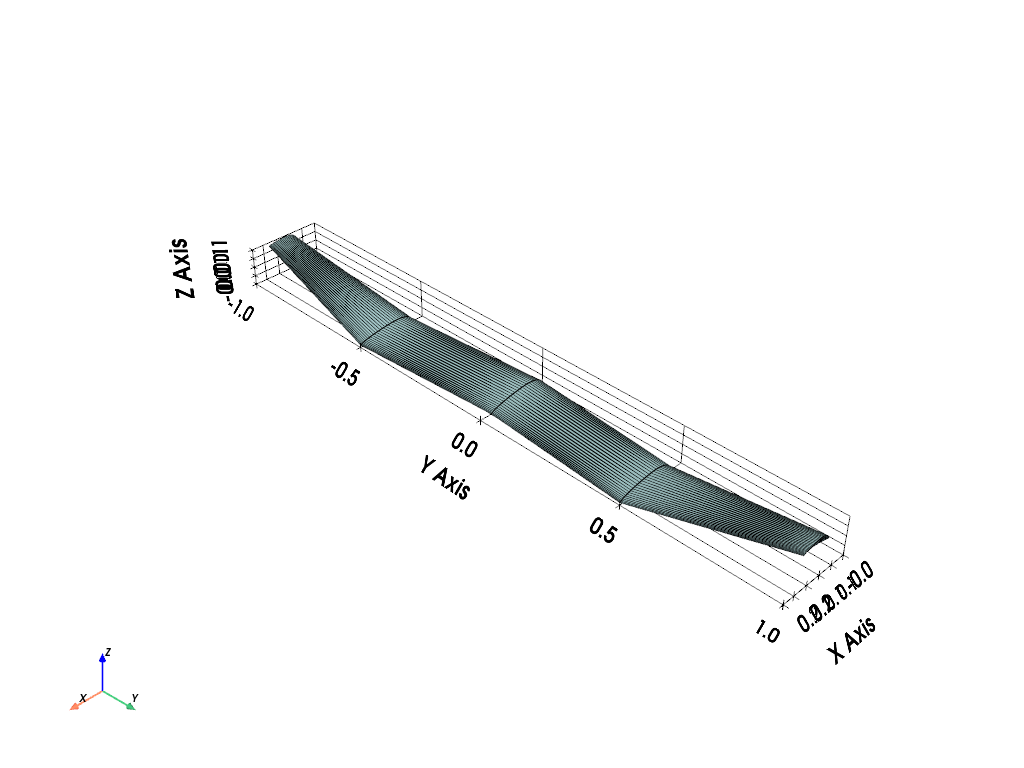

PolyData,Information
N Cells,436
N Points,438
N Strips,0
X Bounds,"-9.093e-06, 2.400e-01"
Y Bounds,"-1.000e+00, 1.000e+00"
Z Bounds,"-6.980e-03, 1.144e-01"
N Arrays,0


In [45]:
wing.draw(show_kwargs=dict(jupyter_backend="static"))

In [46]:
# implementing vortex lattice
vlm = asb.VortexLatticeMethod(
    airplane=wing, # we don't have an airplane
    op_point=asb.OperatingPoint(
        velocity=13.4,  # m/s, about 30 mph
        alpha=5,  # angle of attack, degrees
    )
)

In [47]:
aero = vlm.run()  # Returns a dictionary that's absolutely awful to look at
for k, v in aero.items():
    print(f"{k.rjust(4)} : {v}")

 F_g : [-2.68164671e+00  3.29944405e-15  5.97148195e+01]
 F_b : (np.float64(2.681646714497342), np.float64(3.299444051307887e-15), np.float64(-59.71481947577115))
 F_w : (np.float64(-2.5330472053157576), np.float64(3.299444051307887e-15), np.float64(-59.72130747045776))
 M_g : [-7.33441086e-15 -7.29668553e+00 -2.77555756e-17]
 M_b : (np.float64(7.33441085642994e-15), np.float64(-7.296685534458799), np.float64(2.7755575615628914e-17))
 M_w : (np.float64(7.308920266610214e-15), np.float64(-7.296685534458799), np.float64(-6.11586068537865e-16))
   L : 59.72130747045776
   D : 2.5330472053157576
   Y : 3.299444051307887e-15
 l_b : 7.33441085642994e-15
 m_b : -7.296685534458799
 n_b : 2.7755575615628914e-17
  CL : 1.5384154304257225
  CD : 0.06525106484954599
  CY : 8.499337766289372e-17
  Cl : 9.354029111164543e-17
  Cm : -1.039965214635472
  Cn : 3.5398407232410763e-19


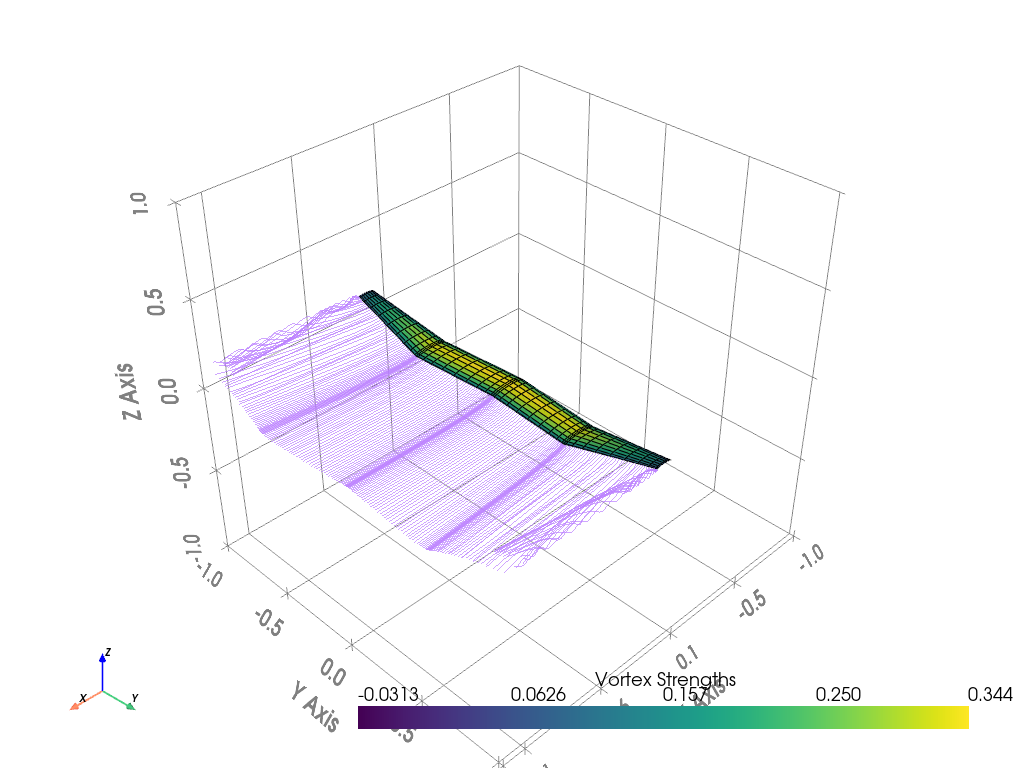

In [48]:
# nice pictures to look at
vlm.draw(show_kwargs=dict(jupyter_backend="static")) # use notebook backend

# Operating Point Optimization

In [49]:
lift_over_drag = aero['CL']/aero['CD']
print("L/D: ", lift_over_drag)

L/D:  23.5768632124695


In [50]:
opti = asb.Opti() # initialize optimizer

alpha = opti.variable(init_guess=5)

vlm = asb.VortexLatticeMethod(
    airplane=wing,
    op_point=asb.OperatingPoint(
        velocity=13.4,
        alpha=alpha
    ),
    align_trailing_vortices_with_wind=False,
)

aero = vlm.run()

L_over_D = aero["CL"] / aero["CD"]

opti.minimize(-L_over_D)
sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -2.3576863e+01 0.00e+00 6.83e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

In [51]:
optimal_alpha = sol(alpha)
print(f"Alpha for max L/D: {optimal_alpha:.3f} deg")

Alpha for max L/D: -10.469 deg


Total solve time for optimal alpha was 2.44s.

# Aero shape optimization
### Finding the minimum induced drag.

In [52]:
opti = asb.Opti()  # Initialize an optimization environment.

N = 16  # Number of chord sections to optimize

# The y-locations (i.e. span locations) of each section. Note that the span is fixed.
section_y = np.sinspace(0, 1, N, reverse_spacing=True)
# Using `sinspace` gives us better resolution near the wing tip.

In [53]:
# going to optimize chord length, initially guess all chords = 1
chords = opti.variable(init_guess=np.ones(N)) # All chords initially guessed as "1".

wing = asb.Wing(
    symmetric=True,
    xsecs=[
        asb.WingXSec(
            xyz_le=[
                -0.25 * chords[i], # This keeps the quarter-chord-line straight.
                section_y[i], # Our (known) span locations for each section.
                0
            ],
            chord=chords[i], # all 1s initially, this is not a number but an element of type MX to optimize
            airfoil=wing_airfoil
        )
        for i in range(N) # looping through number of chord sections to optimize
    ]
)

airplane = asb.Airplane( # airplane is just a class that contains wings
    wings=[
        wing
    ]
)


In [57]:
chords[0][0]

MX(opti5_x_1[0])

In [70]:
# show an example of what the first iteration wing will look like
# can't draw from the code directly above because the actual wing components are of type MX
# which is a data type CasADi uses to numerically optimize rather than something that is drawable by aerosandbox
example_wing = asb.Wing(
    name='Main Wing',
    symmetric=True,
    xsecs=[
        asb.WingXSec(
            xyz_le = [0,0,0],
            chord = 1, # our first initial guess
            airfoil=wing_airfoil
        ),

        asb.WingXSec(
            xyz_le = [0,0.5,0],
            chord = 1, # our first initial guess
            airfoil=wing_airfoil
        ),
    ]
)

example_airplane = asb.Airplane(wings=[example_wing])


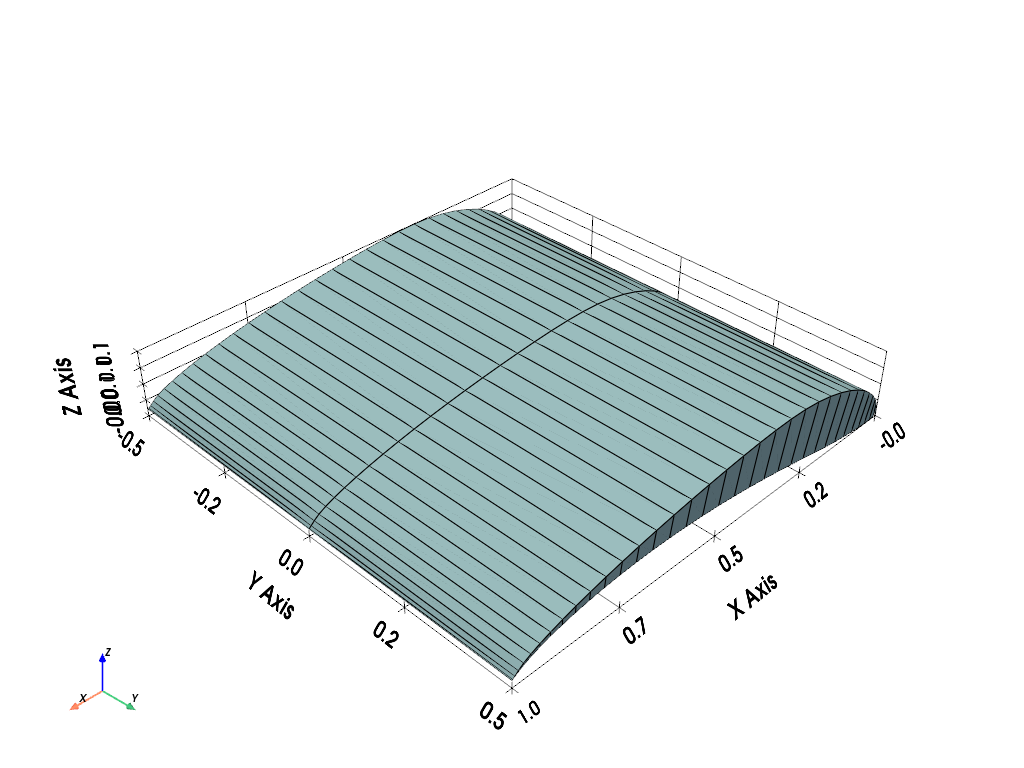

PolyData,Information
N Cells,290
N Points,292
N Strips,0
X Bounds,"-2.000e-05, 1.000e+00"
Y Bounds,"-5.000e-01, 5.000e-01"
Z Bounds,"-1.568e-02, 1.353e-01"
N Arrays,0


In [74]:
# initial guess is kinda this vibe but 16 times instead of 2
example_airplane.draw(show_kwargs=dict(jupyter_backend="static"))

In [72]:
# adding constraints to what chord values can be (always positive) and fixed wing area
opti.subject_to([
    chords > 0,  
    wing.area() == 0.25, 
])

[MX(fabs(opti5_lam_g_1)), MX(fabs(opti5_lam_g_2))]

In [25]:
# tapering? added constraint to make solving easier apparently
opti.subject_to(
    np.diff(chords) <= 0 # The change in chord from one section to the next should be negative.
)

MX(fabs(opti2_lam_g_8))

In [26]:
alpha = opti.variable(init_guess=5, lower_bound=0, upper_bound=30) # also optimizing for angle of attack

op_point = asb.OperatingPoint(
    velocity=13.4, # fixed velocity (does not matter, this is nondimensional)
    alpha=alpha
)

vlm = asb.VortexLatticeMethod(
    airplane=airplane,
    op_point=op_point,
    spanwise_resolution=1,
    chordwise_resolution=8,
)

aero = vlm.run()

In [27]:
print(type(vlm))

<class 'aerosandbox.aerodynamics.aero_3D.vortex_lattice_method.VortexLatticeMethod'>


In [28]:
# ok we can't actually draw this initial guess because our objects are of type MX which is what CasADi takes in
# for numerical optimization

# we definitely can show a picture of the initial guess if we run VLM a little higher up (I think)
# actually does not matter one bit if we can draw it or not though

# vlm.draw(show_kwargs=dict(jupyter_backend="static")) # commented bc it gives error, but the spirit of it is left for pondering

In [29]:
# hold CL constant (since we are optimizing drag)
opti.subject_to(
    aero["CL"] == 1
)

opti.minimize(aero["CD"])

sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       49
Number of nonzeros in inequality constraint Jacobian.:       96
Number of nonzeros in Lagrangian Hessian.............:      184

Total number of variables............................:       34
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        3
Total number of inequality constraints...............:       66
        inequality constraints with only lower bounds:       34
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       32

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.9988005e-01 1.75e+00 5.70e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

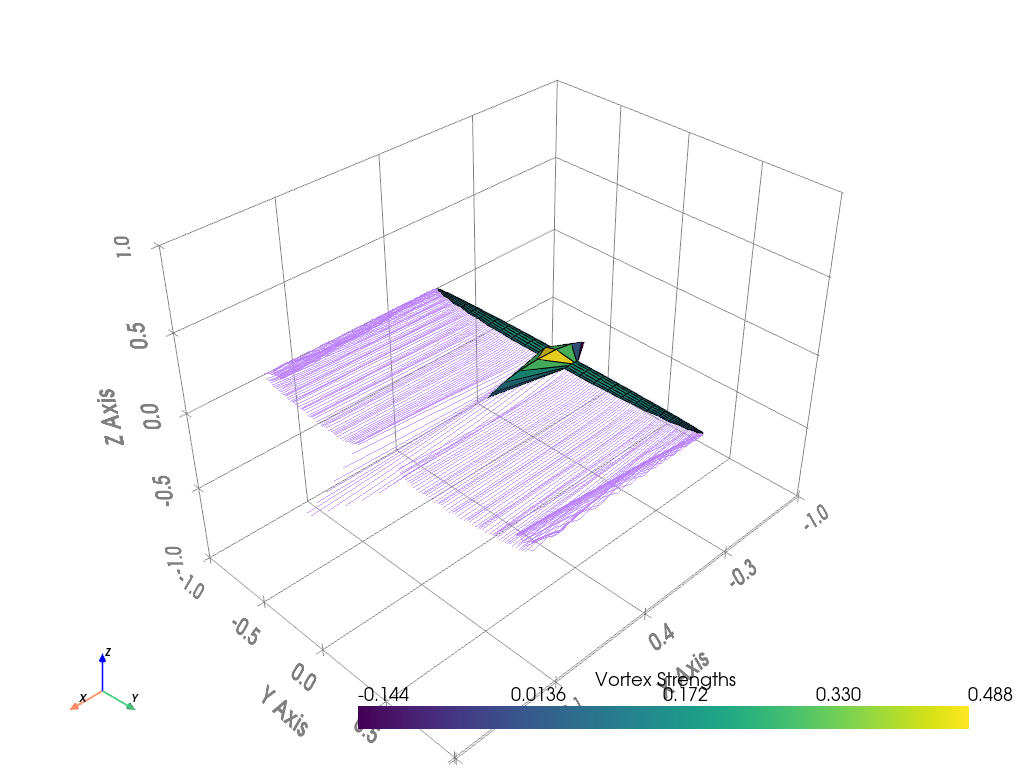

In [30]:
vlm = sol(vlm)

vlm.draw(show_kwargs=dict(jupyter_backend="static"))

### So this is supposed to be the optimized wing. Pretty weird looking, I have to say.

In [76]:
print(sol(aero['CD'])) # optimized drag coefficient

0.0011062547001431553


In [78]:
for k,v in sol(aero).items():
    print("{}: {}".format(k, v))
    print()

F_g: [1.05900739e+00 4.83771009e-16 5.49480145e+00]

F_b: (-1.0590073886351552, 4.837710093630321e-16, -5.494801454714091)

F_w: (-0.042944822173036745, 4.837710093630321e-16, -5.595756911996845)

M_g: [-1.58033309e-15 -2.79329554e+00  5.13044468e-16]

M_b: (1.5803330866148713e-15, -2.793295540735452, -5.130444680201407e-16)

M_w: (1.6472481816976177e-15, -2.793295540735452, -2.1734930114828487e-16)

L: 5.595756911996845

D: 0.042944822173036745

Y: 4.837710093630321e-16

l_b: 1.5803330866148713e-15

m_b: -2.793295540735452

n_b: -5.130444680201407e-16

CL: 0.14414618739862214

CD: 0.0011062547001431553

CY: 1.2461897053490792e-17

Cl: 2.015496811795388e-17

Cm: -0.39811640269306364

Cn: -6.543174336865926e-18

